# Coffea Delivery Notebook

### Import Libraries and Packages

In [470]:
import numpy as np
import pandas as pd
import json
import geopy
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from bs4 import BeautifulSoup as bs
print('Libraries imported.')

Libraries imported.


### Read csv listing Average Rent in Each DC Neighborhood

In [404]:
df = pd.read_csv('AvgRentDC.csv')
df

,Neighborhood,Average Rent
0,Federal Triangle,"$2,891.00"
1,West End Washington,"$2,645.00"
2,Navy Yard,"$2,549.00"
3,Bloomingdale,"$2,513.00"
4,Chinatown,"$2,513.00"
...,...,...
129,Kenilworth Park,"$1,245.00"
130,Lincoln Heights,"$1,245.00"
131,Marshall Heights,"$1,245.00"
132,Mayfair,"$1,245.00"


### Acquire Coordinates for DC

In [50]:
address = 'Washington, DC'
geolocator = geopy.Nominatim(user_agent="dc_explorer", timeout=30)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Washington, DC {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Washington, DC 38.8949924, -77.0365581.


### Clean Dataframe to suit needs

In [336]:
fulladd =[]
for x in np.unique(df.Neighborhood):
    address = x + ", Washington, DC"
    fulladd.append(address)

fulladd.remove(fulladd[4])
fulladd.remove(fulladd[13])
fulladd.remove(fulladd[52])
fulladd.remove(fulladd[73])
fulladd.remove(fulladd[86])
fulladd.remove(fulladd[93])
fulladd.remove(fulladd[102])
n_fulladd = len(fulladd)
n_fulladd

['16th Street Heights, Washington, DC',
 'Adams Morgan, Washington, DC',
 'American University Park, Washington, DC',
 'Anacostia, Washington, DC',
 'Arboretum, Washington, DC',
 'Barnaby Woods, Washington, DC',
 'Barney Circle, Washington, DC',
 'Barry Farm, Washington, DC',
 'Bellevue, Washington, DC',
 'Benning, Washington, DC',
 'Benning Heights, Washington, DC',
 'Benning Ridge, Washington, DC',
 'Bloomingdale, Washington, DC',
 'Brentwood, Washington, DC',
 'Brightwood, Washington, DC',
 'Brightwood Park, Washington, DC',
 'Brookland, Washington, DC',
 'Buena Vista, Washington, DC',
 'Burleith, Washington, DC',
 'Burrville, Washington, DC',
 'Capitol Hill, Washington, DC',
 'Capitol View, Washington, DC',
 'Carver - Langston, Washington, DC',
 'Cathedral Heights, Washington, DC',
 'Central Northeast, Washington, DC',
 'Chevy Chase, Washington, DC',
 'Chinatown, Washington, DC',
 'Civic Betterment, Washington, DC',
 'Cleveland Park, Washington, DC',
 'Colonial Village, Washington,

In [168]:
df = df.rename(columns={'Average Rent': 'AvgRent'})

In [172]:
newrent = []
for x in df.AvgRent:
    newrent.append(x)
newrent.remove(newrent[4])
newrent.remove(newrent[13])
newrent.remove(newrent[52])
newrent.remove(newrent[73])
newrent.remove(newrent[86])
newrent.remove(newrent[93])
newrent.remove(newrent[102])
n_newrent = len(newrent)
n_newrent

127

In [467]:
new_df

,Neighborhood,Latitude,Longitude
0,"16th Street Heights, Washington, DC",38.950332,-77.032719
1,"Adams Morgan, Washington, DC",38.921500,-77.042199
2,"American University Park, Washington, DC",38.947320,-77.091283
3,"Anacostia, Washington, DC",38.862581,-76.984441
4,"Arboretum, Washington, DC",38.913797,-76.972694
...,...,...,...
122,"West Potomac Park, Washington, DC",38.886381,-77.046576
123,"Woodland, Washington, DC",38.857127,-76.973686
124,"Woodland - Normanstone, Washington, DC",38.923681,-77.061477
125,"Woodley Park, Washington, DC",38.925025,-77.052363


### Map DC using Neighborhood Coordinates

In [471]:
map_dc = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map based on coordinates of postcode
for lat, lng, neighborhood in zip(new_df['Latitude'], new_df['Longitude'], new_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dc)  
    
map_dc

In [338]:
geo_lat = []
geo_lon = []
i = 0
for i in range(0, n_fulladd):
    location = geolocator.geocode(fulladd[i])
    geo_lat.append(location.latitude)
    geo_lon.append(location.longitude)

### Add Coordinates for Neighborhoods

In [145]:
data = {'Neighborhood': fulladd, 'Latitude': geo_lat, 'Longitude': geo_lon}
new_df = pd.DataFrame(data)
new_df

,Neighborhood,Latitude,Longitude
0,"16th Street Heights, Washington, DC",38.950332,-77.032719
1,"Adams Morgan, Washington, DC",38.921500,-77.042199
2,"American University Park, Washington, DC",38.947320,-77.091283
3,"Anacostia, Washington, DC",38.862581,-76.984441
4,"Arboretum, Washington, DC",38.913797,-76.972694
...,...,...,...
122,"West Potomac Park, Washington, DC",38.886381,-77.046576
123,"Woodland, Washington, DC",38.857127,-76.973686
124,"Woodland - Normanstone, Washington, DC",38.923681,-77.061477
125,"Woodley Park, Washington, DC",38.925025,-77.052363


## Use FourSquare to get info on Venues

In [151]:
#Define Foursquare Credentials
CLIENT_ID = 'MFH2DLRQJPOBRV43XVOAX1UYJSHLGD0EU0BXXQGUPHWGBOEQ' # your Foursquare ID
CLIENT_SECRET = 'EAYFB4G2MNQAG0UJS3ME5UVAYV1CNGCXQPPGO1ENYIJNZP5L' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MFH2DLRQJPOBRV43XVOAX1UYJSHLGD0EU0BXXQGUPHWGBOEQ
CLIENT_SECRET:EAYFB4G2MNQAG0UJS3ME5UVAYV1CNGCXQPPGO1ENYIJNZP5L


In [295]:

# define limit = 5 (limit to 5 venues only) & radius = 500 (meters)
LIMIT = 5
radius = 500

location_list = [] # initiate a list to store data from Foursquare API requests

for neighbourhood, latitude, longitude in zip(new_df.Neighborhood, new_df.Latitude, new_df.Longitude):
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
    
    data = requests.get(url).json()
    
    # use len() to check if any data within "items" (len = 0 if nothing)
    length = len(data['response']['groups'][0]['items'])
    if length == 0:
        continue # skip the row if nothing is found
    else:
        venue = data['response']['groups'][0]['items'][0]['venue']
        
        # extract info within 'venue'
        name = venue['name']
        lat = venue['location']['lat']
        lon = venue['location']['lng']
        cat = venue['categories'][0]['name']
        
        location_list.append([(neighbourhood, latitude, longitude, name, lat, lon, cat)])

In [296]:
# create data frame based on 'Location_list'

temp = pd.DataFrame(x for row in location_list for x in row)
temp.columns = ['Neighbourhood','Latitude','Longitude','Venue','Latitude','Longitude','Category']
temp['Category']


0              Coffee Shop
1        Afghan Restaurant
2       Seafood Restaurant
3           History Museum
4         Botanical Garden
              ...         
117    Monument / Landmark
118                 Museum
119      Outdoor Sculpture
120           Liquor Store
121            Coffee Shop
Name: Category, Length: 122, dtype: object

In [297]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ffb5812f77af50c9b4da4c8'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Northeast Washington',
  'headerFullLocation': 'Northeast Washington, Washington',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 15,
  'suggestedBounds': {'ne': {'lat': 38.935729004500004,
    'lng': -76.96530569553329},
   'sw': {'lat': 38.9267289955, 'lng': -76.97685370446672}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51ca1d70498e8043d40fd959',
       'name': "Zeke's Coffee",
       'location': {'address': '2300 Rhode Island NE',
        'lat': 38.93055962279985,
        'lng': -76.97327128403894,
        'labeledLatLngs': [{'label': 'display

In [298]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [299]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]


In [300]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [301]:
dc_venues = getNearbyVenues(names=new_df['Neighborhood'],
                                   latitudes=new_df['Latitude'],
                                   longitudes=new_df['Longitude']
                                  )

16th Street Heights, Washington, DC
Adams Morgan, Washington, DC
American University Park, Washington, DC
Anacostia, Washington, DC
Arboretum, Washington, DC
Barnaby Woods, Washington, DC
Barney Circle, Washington, DC
Barry Farm, Washington, DC
Bellevue, Washington, DC
Benning, Washington, DC
Benning Heights, Washington, DC
Benning Ridge, Washington, DC
Bloomingdale, Washington, DC
Brentwood, Washington, DC
Brightwood, Washington, DC
Brightwood Park, Washington, DC
Brookland, Washington, DC
Buena Vista, Washington, DC
Burleith, Washington, DC
Burrville, Washington, DC
Capitol Hill, Washington, DC
Capitol View, Washington, DC
Carver - Langston, Washington, DC
Cathedral Heights, Washington, DC
Central Northeast, Washington, DC
Chevy Chase, Washington, DC
Chinatown, Washington, DC
Civic Betterment, Washington, DC
Cleveland Park, Washington, DC
Colonial Village, Washington, DC
Columbia Heights Dc Washington, Washington, DC
Congress Heights, Washington, DC
Crestwood, Washington, DC
Deanwood

In [302]:
print(dc_venues.shape)
dc_venues.head()

(563, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"16th Street Heights, Washington, DC",38.950332,-77.032719,Highlands Cafe,38.947523,-77.032795,Coffee Shop
1,"16th Street Heights, Washington, DC",38.950332,-77.032719,Smokey's Fried Chicken,38.947652,-77.032780,Diner
2,"16th Street Heights, Washington, DC",38.950332,-77.032719,Dance Loft on 14,38.946584,-77.032893,Gymnastics Gym
3,"16th Street Heights, Washington, DC",38.950332,-77.032719,Hamilton Park Playground,38.952645,-77.031494,Playground
4,"16th Street Heights, Washington, DC",38.950332,-77.032719,14th Street Snack Bar,38.946679,-77.033001,Breakfast Spot


In [303]:
dc_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"16th Street Heights, Washington, DC",5,5,5,5,5,5
"Adams Morgan, Washington, DC",5,5,5,5,5,5
"American University Park, Washington, DC",5,5,5,5,5,5
"Anacostia, Washington, DC",5,5,5,5,5,5
"Arboretum, Washington, DC",5,5,5,5,5,5
...,...,...,...,...,...,...
"West Potomac Park, Washington, DC",5,5,5,5,5,5
"Woodland - Normanstone, Washington, DC",4,4,4,4,4,4
"Woodland, Washington, DC",5,5,5,5,5,5


In [304]:
print('There are {} uniques categories.'.format(len(dc_venues['Venue Category'].unique())))

There are 185 uniques categories.


In [305]:
# one hot encoding
dc_onehot = pd.get_dummies(dc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dc_onehot['Neighborhood'] = dc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dc_onehot.columns[-1]] + list(dc_onehot.columns[:-1])
dc_onehot = dc_onehot[fixed_columns]

dc_onehot.head()

,Yoga Studio,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,...,Theater,Thrift / Vintage Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [306]:
dc_onehot.shape

(563, 185)

In [307]:
dc_grouped = dc_onehot.groupby('Neighborhood').mean().reset_index()
dc_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Athletics & Sports,Automotive Shop,BBQ Joint,...,Theater,Thrift / Vintage Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint
0,"16th Street Heights, Washington, DC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Adams Morgan, Washington, DC",0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"American University Park, Washington, DC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Anacostia, Washington, DC",0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Arboretum, Washington, DC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,"West Potomac Park, Washington, DC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,"Woodland - Normanstone, Washington, DC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119,"Woodland, Washington, DC",0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120,"Woodley Park, Washington, DC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [374]:
dc_grouped.shape

(122, 185)

## Isolate neighborhoods listing Coffee Shops as top venues

In [442]:
len(dc_grouped[dc_grouped["Coffee Shop"] > 0])
coffee = dc_grouped[dc_grouped["Coffee Shop"] > 0]
data = [coffee['Neighborhood'], coffee['Coffee Shop']]
coffee_df = pd.DataFrame(data).transpose()
coffee_df

,Neighborhood,Coffee Shop
0,"16th Street Heights, Washington, DC",0.2
2,"American University Park, Washington, DC",0.2
16,"Buena Vista, Washington, DC",0.2
21,"Carver - Langston, Washington, DC",0.2
24,"Chinatown, Washington, DC",0.2
50,"Gallaudet, Washington, DC",0.2
65,"Kenilworth Park, Washington, DC",0.25
66,"Kenilworth, Washington, DC",0.25
78,"McLean Gardens, Washington, DC",0.2
82,"Navy Yard, Washington, DC",0.2


## Combine Rent and Coffee Neighborhood Data

In [443]:
rent = []
for x in range(0,16):
    neigh = coffee_df.iloc[x]['Neighborhood']
    neigh2 = neigh.replace(', Washington, DC','')
    rent0 = df[df['Neighborhood']== neigh2]
    rent1 = rent0.iloc[0]['Average Rent']
    rent2 = rent1.replace('$','')
    rent3 = rent2.replace(',','')
    rent4 = float(rent3)
    rent.append(rent4)
    
coffee_df['AvgRent ($)'] = rent

coffee_df
# coffee_df.iloc[]
# rent2 = df[df['Neighborhood']=='16th Street Heights']
# rent3 = rent2.iloc[0]['Average Rent']
# rent4 = rent3.replace('$','')
# rent4

,Neighborhood,Coffee Shop,AvgRent ($)
0,"16th Street Heights, Washington, DC",0.2,1723.0
2,"American University Park, Washington, DC",0.2,2075.0
16,"Buena Vista, Washington, DC",0.2,1261.0
21,"Carver - Langston, Washington, DC",0.2,2260.0
24,"Chinatown, Washington, DC",0.2,2513.0
50,"Gallaudet, Washington, DC",0.2,2260.0
65,"Kenilworth Park, Washington, DC",0.25,1245.0
66,"Kenilworth, Washington, DC",0.25,1245.0
78,"McLean Gardens, Washington, DC",0.2,2075.0
82,"Navy Yard, Washington, DC",0.2,2549.0


## Plot Coffee Neighborhood Rent Data to visualize

In [444]:
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors

Text(0.5, 1.0, 'Average Rent in Neighborhoods with Coffee Shops as Top Venue')

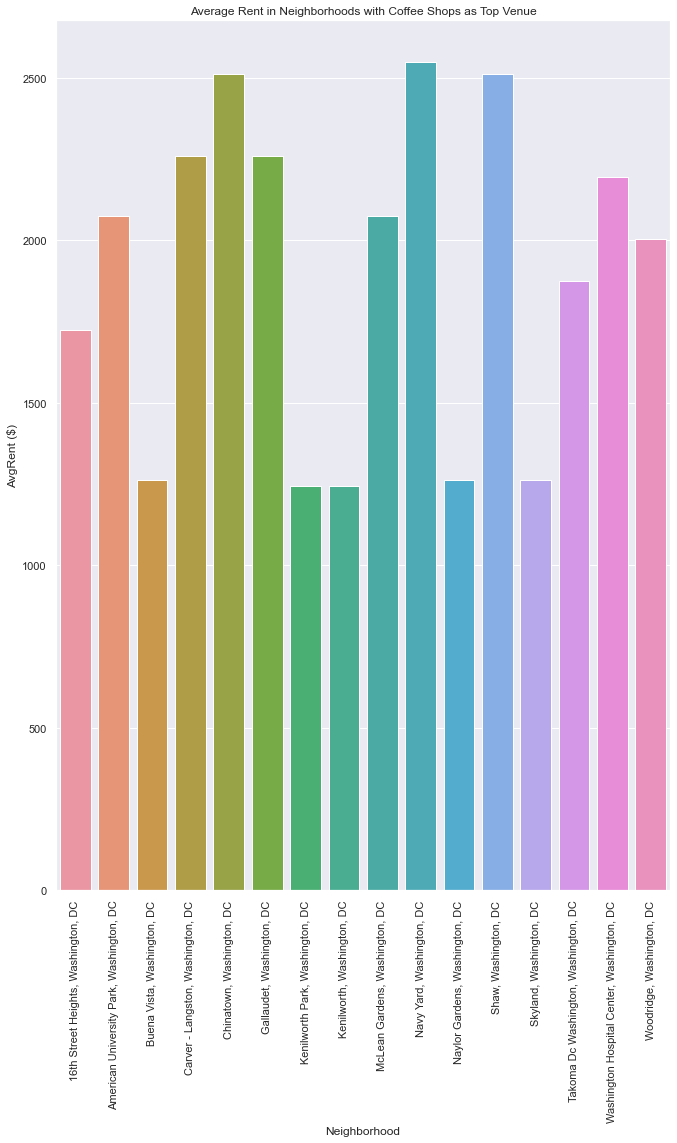

In [447]:
sns.set(rc={'figure.figsize':(11,16)})
plot = sns.barplot(x='Neighborhood',y='AvgRent ($)',data=coffee_df)
plot.set_xticklabels(coffee_df['Neighborhood'],rotation=90)
plot.set_title('Average Rent in Neighborhoods with Coffee Shops as Top Venue')

## Use K-Means Clustering to further analyze

In [455]:
# set number of clusters
kclusters = 3

dc_clustering = coffee_df.drop(["Neighborhood"], 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dc_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 0, 1, 1, 1, 0, 0, 2, 1], dtype=int32)

In [451]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
dc_merged = coffee_df.copy()

# add clustering labels
dc_merged["Cluster Labels"] = kmeans.labels_

In [456]:
dc_merged

,Neighborhood,Coffee Shop,AvgRent ($),Cluster Labels
0,"16th Street Heights, Washington, DC",0.2,1723.0,2
2,"American University Park, Washington, DC",0.2,2075.0,2
16,"Buena Vista, Washington, DC",0.2,1261.0,0
21,"Carver - Langston, Washington, DC",0.2,2260.0,1
24,"Chinatown, Washington, DC",0.2,2513.0,1
50,"Gallaudet, Washington, DC",0.2,2260.0,1
65,"Kenilworth Park, Washington, DC",0.25,1245.0,0
66,"Kenilworth, Washington, DC",0.25,1245.0,0
78,"McLean Gardens, Washington, DC",0.2,2075.0,2
82,"Navy Yard, Washington, DC",0.2,2549.0,1


In [457]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dc_merged = dc_merged.join(new_df.set_index("Neighborhood"), on="Neighborhood")

print(dc_merged.shape)
dc_merged.head() # check the last columns!

(16, 6)


,Neighborhood,Coffee Shop,AvgRent ($),Cluster Labels,Latitude,Longitude
0,"16th Street Heights, Washington, DC",0.2,1723.0,2,38.950332,-77.032719
2,"American University Park, Washington, DC",0.2,2075.0,2,38.947320,-77.091283
16,"Buena Vista, Washington, DC",0.2,1261.0,0,38.856653,-76.968680
21,"Carver - Langston, Washington, DC",0.2,2260.0,1,38.903950,-76.977638
24,"Chinatown, Washington, DC",0.2,2513.0,1,38.900342,-77.021443


In [458]:
# sort the results by Cluster Labels
print(dc_merged.shape)
dc_merged.sort_values(["Cluster Labels"], inplace=True)
dc_merged

(16, 6)


,Neighborhood,Coffee Shop,AvgRent ($),Cluster Labels,Latitude,Longitude
16,"Buena Vista, Washington, DC",0.2,1261.0,0,38.856653,-76.968680
65,"Kenilworth Park, Washington, DC",0.25,1245.0,0,38.909328,-76.939165
66,"Kenilworth, Washington, DC",0.25,1245.0,0,38.909328,-76.939165
83,"Naylor Gardens, Washington, DC",0.2,1261.0,0,38.856348,-76.966299
101,"Skyland, Washington, DC",0.333333,1261.0,0,38.860111,-76.972115
21,"Carver - Langston, Washington, DC",0.2,2260.0,1,38.903950,-76.977638
24,"Chinatown, Washington, DC",0.2,2513.0,1,38.900342,-77.021443
50,"Gallaudet, Washington, DC",0.2,2260.0,1,38.906618,-76.993439
82,"Navy Yard, Washington, DC",0.2,2549.0,1,38.876307,-77.000478
98,"Shaw, Washington, DC",0.2,2513.0,1,38.912056,-77.021365


## Map Clusters of Coffee-Neighborhoods

In [469]:
# create map
map_clusters_coffee = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dc_merged['Latitude'], dc_merged['Longitude'], dc_merged['Neighborhood'], dc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_coffee)
       
map_clusters_coffee

In [465]:
# save the map as HTML file
map_clusters_coffee.save('map_clusters_coffee.html')

In [309]:
num_top_venues = 5

for hood in dc_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = dc_grouped[dc_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----16th Street Heights, Washington, DC----
            venue  freq
0           Diner   0.2
1      Playground   0.2
2  Gymnastics Gym   0.2
3     Coffee Shop   0.2
4  Breakfast Spot   0.2


----Adams Morgan, Washington, DC----
                      venue  freq
0         Afghan Restaurant   0.2
1       Japanese Restaurant   0.2
2  Mediterranean Restaurant   0.2
3              Cocktail Bar   0.2
4                     Hotel   0.2


----American University Park, Washington, DC----
                    venue  freq
0           Deli / Bodega   0.2
1  Furniture / Home Store   0.2
2             Pizza Place   0.2
3             Coffee Shop   0.2
4      Seafood Restaurant   0.2


----Anacostia, Washington, DC----
                 venue  freq
0        Grocery Store   0.2
1  American Restaurant   0.2
2    Convenience Store   0.2
3       History Museum   0.2
4       Sandwich Place   0.2


----Arboretum, Washington, DC----
                  venue  freq
0               Brewery   0.2
1    Chinese Restaur

                      venue  freq
0               Wings Joint   0.2
1               Post Office   0.2
2  Bike Rental / Bike Share   0.2
3               Pizza Place   0.2
4             Shopping Mall   0.2


----Fairlawn, Washington, DC----
              venue  freq
0     Deli / Bodega   0.2
1    Sandwich Place   0.2
2              Park   0.2
3  Basketball Court   0.2
4               Gym   0.2


----Federal Triangle, Washington, DC----
                      venue  freq
0      Brazilian Restaurant   0.2
1  Bike Rental / Bike Share   0.2
2                Steakhouse   0.2
3            Science Museum   0.2
4       American Restaurant   0.2


----Foggy Bottom, Washington, DC----
        venue  freq
0       Hotel   0.2
1  Whisky Bar   0.2
2  Restaurant   0.2
3     Theater   0.2
4         Bar   0.2


----Forest Hills, Washington, DC----
                     venue  freq
0               Public Art   1.0
1    Performing Arts Venue   0.0
2              Music Venue   0.0
3  New American Restaurant  

4  Vegetarian / Vegan Restaurant   0.2


----Navy Yard, Washington, DC----
                   venue  freq
0                Brewery   0.2
1  Portuguese Restaurant   0.2
2                   Pool   0.2
3            Coffee Shop   0.2
4   Gym / Fitness Center   0.2


----Naylor Gardens, Washington, DC----
               venue  freq
0        Coffee Shop   0.2
1  Convenience Store   0.2
2       Liquor Store   0.2
3               Bank   0.2
4     Sandwich Place   0.2


----Near Northeast, Washington, DC----
                           venue  freq
0                    Yoga Studio   0.2
1  Vegetarian / Vegan Restaurant   0.2
2                  Grocery Store   0.2
3            Sporting Goods Shop   0.2
4              Indian Restaurant   0.2


----North Capitol Street, Washington, DC----
                 venue  freq
0          Music Venue   0.2
1                 Pool   0.2
2   Turkish Restaurant   0.2
3   Seafood Restaurant   0.2
4  Peruvian Restaurant   0.2


----North Cleveland Park, Washington, 

In [364]:
dc_merged.loc[dc_merged['Cluster Labels'] == 0]

,Neighborhood,Coffee Shop,Cluster Labels,Latitude,Longitude
60,"Hillcrest, Washington, DC",0.0,0,38.862057,-76.958030
77,"Mayfair, Washington, DC",0.0,0,38.904437,-76.949695
76,"Massachusetts Heights, Washington, DC",0.0,0,38.917653,-77.058178
75,"Marshall Heights, Washington, DC",0.0,0,38.886314,-76.928910
74,"Manor Park, Washington, DC",0.0,0,38.963999,-77.015810
...,...,...,...,...,...
31,"Douglass, Washington, DC",0.0,0,38.848446,-76.977753
30,"Deanwood, Washington, DC",0.0,0,38.899838,-76.930114
29,"Crestwood, Washington, DC",0.0,0,38.941778,-77.040532
28,"Congress Heights, Washington, DC",0.0,0,38.842897,-77.000255


In [366]:
dc_merged.loc[dc_merged['Cluster Labels'] == 1]


,Neighborhood,Coffee Shop,Cluster Labels,Latitude,Longitude
113,"Washington Hospital Center, Washington, DC",0.20,1,38.928749,-77.014769
0,"16th Street Heights, Washington, DC",0.20,1,38.950332,-77.032719
98,"Shaw, Washington, DC",0.20,1,38.912056,-77.021365
83,"Naylor Gardens, Washington, DC",0.20,1,38.856348,-76.966299
82,"Navy Yard, Washington, DC",0.20,1,38.876307,-77.000478
78,"McLean Gardens, Washington, DC",0.20,1,38.937333,-77.075256
66,"Kenilworth, Washington, DC",0.25,1,38.909328,-76.939165
65,"Kenilworth Park, Washington, DC",0.25,1,38.909328,-76.939165
50,"Gallaudet, Washington, DC",0.20,1,38.906618,-76.993439
24,"Chinatown, Washington, DC",0.20,1,38.900342,-77.021443


In [310]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [311]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dc_grouped['Neighborhood']

for ind in np.arange(dc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"16th Street Heights, Washington, DC",Breakfast Spot,Playground,Gymnastics Gym,Diner,Coffee Shop,Wings Joint,Drugstore,Field,Fast Food Restaurant,Farmers Market
1,"Adams Morgan, Washington, DC",Hotel,Afghan Restaurant,Mediterranean Restaurant,Japanese Restaurant,Cocktail Bar,Dumpling Restaurant,Food,Fish & Chips Shop,Field,Fast Food Restaurant
2,"American University Park, Washington, DC",Deli / Bodega,Pizza Place,Coffee Shop,Furniture / Home Store,Seafood Restaurant,Wings Joint,Dumpling Restaurant,Field,Fast Food Restaurant,Farmers Market
3,"Anacostia, Washington, DC",Sandwich Place,Convenience Store,American Restaurant,History Museum,Grocery Store,Wings Joint,Field,Fast Food Restaurant,Farmers Market,Escape Room
4,"Arboretum, Washington, DC",Botanical Garden,Brewery,Garden,Fast Food Restaurant,Chinese Restaurant,Electronics Store,Food,Fish & Chips Shop,Field,Farmers Market


In [312]:
# set number of clusters
kclusters = 4

dc_grouped_clustering = dc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 3, 1, 0, 0, 3, 3], dtype=int32)

In [313]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted
# dc_merged = dc_data

# # merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
# dc_merged = dc_merged.join(neighborhoods_venues_sorted, on='Neighborhood')

# dc_merged.head() # check the last columns!

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,"16th Street Heights, Washington, DC",Breakfast Spot,Playground,Gymnastics Gym,Diner,Coffee Shop,Wings Joint,Drugstore,Field,Fast Food Restaurant,Farmers Market
1,0,"Adams Morgan, Washington, DC",Hotel,Afghan Restaurant,Mediterranean Restaurant,Japanese Restaurant,Cocktail Bar,Dumpling Restaurant,Food,Fish & Chips Shop,Field,Fast Food Restaurant
2,0,"American University Park, Washington, DC",Deli / Bodega,Pizza Place,Coffee Shop,Furniture / Home Store,Seafood Restaurant,Wings Joint,Dumpling Restaurant,Field,Fast Food Restaurant,Farmers Market
3,0,"Anacostia, Washington, DC",Sandwich Place,Convenience Store,American Restaurant,History Museum,Grocery Store,Wings Joint,Field,Fast Food Restaurant,Farmers Market,Escape Room
4,3,"Arboretum, Washington, DC",Botanical Garden,Brewery,Garden,Fast Food Restaurant,Chinese Restaurant,Electronics Store,Food,Fish & Chips Shop,Field,Farmers Market
...,...,...,...,...,...,...,...,...,...,...,...,...
117,1,"West Potomac Park, Washington, DC",Monument / Landmark,Park,Fountain,Food & Drink Shop,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Escape Room,Entertainment Service
118,0,"Woodland - Normanstone, Washington, DC",Pedestrian Plaza,Gym,Sculpture Garden,Outdoor Sculpture,Dog Run,Fast Food Restaurant,Farmers Market,Escape Room,Entertainment Service,Electronics Store
119,1,"Woodland, Washington, DC",Museum,Art Gallery,Recreation Center,Bed & Breakfast,Park,Wings Joint,Drugstore,Field,Fast Food Restaurant,Farmers Market
120,0,"Woodley Park, Washington, DC",Boutique,Liquor Store,Breakfast Spot,Cajun / Creole Restaurant,Portuguese Restaurant,Dessert Shop,Diner,Dance Studio,Food,Fish & Chips Shop


In [369]:
neighborhoods_venues_sorted['Latitude'] = new_df['Latitude']
neighborhoods_venues_sorted['Longitude'] = new_df['Longitude']
dc_merged = neighborhoods_venues_sorted
dc_merged

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude,AvgRent
0,0,"16th Street Heights, Washington, DC",Breakfast Spot,Playground,Gymnastics Gym,Diner,Coffee Shop,Wings Joint,Drugstore,Field,Fast Food Restaurant,Farmers Market,38.950332,-77.032719,"$2,891.00"
1,0,"Adams Morgan, Washington, DC",Hotel,Afghan Restaurant,Mediterranean Restaurant,Japanese Restaurant,Cocktail Bar,Dumpling Restaurant,Food,Fish & Chips Shop,Field,Fast Food Restaurant,38.921500,-77.042199,"$2,645.00"
2,0,"American University Park, Washington, DC",Deli / Bodega,Pizza Place,Coffee Shop,Furniture / Home Store,Seafood Restaurant,Wings Joint,Dumpling Restaurant,Field,Fast Food Restaurant,Farmers Market,38.947320,-77.091283,"$2,549.00"
3,0,"Anacostia, Washington, DC",Sandwich Place,Convenience Store,American Restaurant,History Museum,Grocery Store,Wings Joint,Field,Fast Food Restaurant,Farmers Market,Escape Room,38.862581,-76.984441,"$2,513.00"
4,3,"Arboretum, Washington, DC",Botanical Garden,Brewery,Garden,Fast Food Restaurant,Chinese Restaurant,Electronics Store,Food,Fish & Chips Shop,Field,Farmers Market,38.913797,-76.972694,"$2,513.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,1,"West Potomac Park, Washington, DC",Monument / Landmark,Park,Fountain,Food & Drink Shop,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Escape Room,Entertainment Service,38.832057,-76.994698,"$1,245.00"
118,0,"Woodland - Normanstone, Washington, DC",Pedestrian Plaza,Gym,Sculpture Garden,Outdoor Sculpture,Dog Run,Fast Food Restaurant,Farmers Market,Escape Room,Entertainment Service,Electronics Store,38.928749,-77.014769,"$1,245.00"
119,1,"Woodland, Washington, DC",Museum,Art Gallery,Recreation Center,Bed & Breakfast,Park,Wings Joint,Drugstore,Field,Fast Food Restaurant,Farmers Market,38.876443,-77.017508,"$1,245.00"
120,0,"Woodley Park, Washington, DC",Boutique,Liquor Store,Breakfast Spot,Cajun / Creole Restaurant,Portuguese Restaurant,Dessert Shop,Diner,Dance Studio,Food,Fish & Chips Shop,38.931222,-77.088034,"$1,245.00"


In [466]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dc_merged['Latitude'], dc_merged['Longitude'], dc_merged['Neighborhood'], dc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [335]:
rent = newrent[0:122]
len(rent)
dc_merged['AvgRent'] = rent
dc_merged

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude,AvgRent
0,0,"16th Street Heights, Washington, DC",Breakfast Spot,Playground,Gymnastics Gym,Diner,Coffee Shop,Wings Joint,Drugstore,Field,Fast Food Restaurant,Farmers Market,38.950332,-77.032719,"$2,891.00"
1,0,"Adams Morgan, Washington, DC",Hotel,Afghan Restaurant,Mediterranean Restaurant,Japanese Restaurant,Cocktail Bar,Dumpling Restaurant,Food,Fish & Chips Shop,Field,Fast Food Restaurant,38.921500,-77.042199,"$2,645.00"
2,0,"American University Park, Washington, DC",Deli / Bodega,Pizza Place,Coffee Shop,Furniture / Home Store,Seafood Restaurant,Wings Joint,Dumpling Restaurant,Field,Fast Food Restaurant,Farmers Market,38.947320,-77.091283,"$2,549.00"
3,0,"Anacostia, Washington, DC",Sandwich Place,Convenience Store,American Restaurant,History Museum,Grocery Store,Wings Joint,Field,Fast Food Restaurant,Farmers Market,Escape Room,38.862581,-76.984441,"$2,513.00"
4,3,"Arboretum, Washington, DC",Botanical Garden,Brewery,Garden,Fast Food Restaurant,Chinese Restaurant,Electronics Store,Food,Fish & Chips Shop,Field,Farmers Market,38.913797,-76.972694,"$2,513.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,1,"West Potomac Park, Washington, DC",Monument / Landmark,Park,Fountain,Food & Drink Shop,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Escape Room,Entertainment Service,38.832057,-76.994698,"$1,245.00"
118,0,"Woodland - Normanstone, Washington, DC",Pedestrian Plaza,Gym,Sculpture Garden,Outdoor Sculpture,Dog Run,Fast Food Restaurant,Farmers Market,Escape Room,Entertainment Service,Electronics Store,38.928749,-77.014769,"$1,245.00"
119,1,"Woodland, Washington, DC",Museum,Art Gallery,Recreation Center,Bed & Breakfast,Park,Wings Joint,Drugstore,Field,Fast Food Restaurant,Farmers Market,38.876443,-77.017508,"$1,245.00"
120,0,"Woodley Park, Washington, DC",Boutique,Liquor Store,Breakfast Spot,Cajun / Creole Restaurant,Portuguese Restaurant,Dessert Shop,Diner,Dance Studio,Food,Fish & Chips Shop,38.931222,-77.088034,"$1,245.00"


In [341]:
cluster1 = dc_merged.loc[dc_merged['Cluster Labels'] == 0, dc_merged.columns[[1] + list(range(0, dc_merged.shape[1]))]]


,Neighborhood,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude,AvgRent
0,"16th Street Heights, Washington, DC",0,"16th Street Heights, Washington, DC",Breakfast Spot,Playground,Gymnastics Gym,Diner,Coffee Shop,Wings Joint,Drugstore,Field,Fast Food Restaurant,Farmers Market,38.950332,-77.032719,"$2,891.00"
1,"Adams Morgan, Washington, DC",0,"Adams Morgan, Washington, DC",Hotel,Afghan Restaurant,Mediterranean Restaurant,Japanese Restaurant,Cocktail Bar,Dumpling Restaurant,Food,Fish & Chips Shop,Field,Fast Food Restaurant,38.921500,-77.042199,"$2,645.00"
2,"American University Park, Washington, DC",0,"American University Park, Washington, DC",Deli / Bodega,Pizza Place,Coffee Shop,Furniture / Home Store,Seafood Restaurant,Wings Joint,Dumpling Restaurant,Field,Fast Food Restaurant,Farmers Market,38.947320,-77.091283,"$2,549.00"
3,"Anacostia, Washington, DC",0,"Anacostia, Washington, DC",Sandwich Place,Convenience Store,American Restaurant,History Museum,Grocery Store,Wings Joint,Field,Fast Food Restaurant,Farmers Market,Escape Room,38.862581,-76.984441,"$2,513.00"
6,"Barney Circle, Washington, DC",0,"Barney Circle, Washington, DC",Fast Food Restaurant,Pizza Place,Cocktail Bar,Supermarket,Dive Bar,Wings Joint,Dumpling Restaurant,Fish & Chips Shop,Field,Farmers Market,38.878837,-76.981576,"$2,513.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,"Washington Highlands, Washington, DC",0,"Washington Highlands, Washington, DC",Costume Shop,Snack Place,Grocery Store,Basketball Court,Wings Joint,Drugstore,Field,Fast Food Restaurant,Farmers Market,Escape Room,38.909834,-77.014976,"$1,245.00"
116,"West End Washington, Washington, DC",0,"West End Washington, Washington, DC",Hotel,Trail,New American Restaurant,Movie Theater,Salad Place,Department Store,Dumpling Restaurant,Field,Fast Food Restaurant,Farmers Market,38.939314,-76.994316,"$1,245.00"
118,"Woodland - Normanstone, Washington, DC",0,"Woodland - Normanstone, Washington, DC",Pedestrian Plaza,Gym,Sculpture Garden,Outdoor Sculpture,Dog Run,Fast Food Restaurant,Farmers Market,Escape Room,Entertainment Service,Electronics Store,38.928749,-77.014769,"$1,245.00"
120,"Woodley Park, Washington, DC",0,"Woodley Park, Washington, DC",Boutique,Liquor Store,Breakfast Spot,Cajun / Creole Restaurant,Portuguese Restaurant,Dessert Shop,Diner,Dance Studio,Food,Fish & Chips Shop,38.931222,-77.088034,"$1,245.00"


In [317]:
dc_merged.loc[dc_merged['Cluster Labels'] == 1, dc_merged.columns[[1] + list(range(0, dc_merged.shape[1]))]]

,Neighborhood,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
5,"Barnaby Woods, Washington, DC",1,"Barnaby Woods, Washington, DC",Field,Gym / Fitness Center,BBQ Joint,Park,Wings Joint,Drugstore,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Escape Room,38.974833,-77.059700
12,"Bloomingdale, Washington, DC",1,"Bloomingdale, Washington, DC",Yoga Studio,Wine Bar,Pizza Place,Italian Restaurant,Park,Dog Run,Field,Fast Food Restaurant,Farmers Market,Escape Room,38.916778,-77.011365
23,"Central Northeast, Washington, DC",1,"Central Northeast, Washington, DC",Park,Wings Joint,Drugstore,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Escape Room,Entertainment Service,Electronics Store,38.934578,-77.082190
37,"Eckington, Washington, DC",1,"Eckington, Washington, DC",Yoga Studio,Caribbean Restaurant,Italian Restaurant,Park,Pub,Art Museum,Arts & Entertainment,Food,Fish & Chips Shop,Field,38.872378,-76.963970
40,"Fairlawn, Washington, DC",1,"Fairlawn, Washington, DC",Park,Sandwich Place,Deli / Bodega,Gym,Basketball Court,Field,Fast Food Restaurant,Farmers Market,Escape Room,Entertainment Service,38.906077,-76.943067
51,"Garfield Heights, Washington, DC",1,"Garfield Heights, Washington, DC",Park,Museum,Art Gallery,Wings Joint,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Escape Room,Entertainment Service,38.951811,-77.002162
64,"Kalorama Heights, Washington, DC",1,"Kalorama Heights, Washington, DC",Park,History Museum,Sushi Restaurant,Scenic Lookout,Dog Run,Fast Food Restaurant,Farmers Market,Escape Room,Entertainment Service,Electronics Store,38.862057,-76.958030
65,"Kenilworth Park, Washington, DC",1,"Kenilworth Park, Washington, DC",Park,Recreation Center,Storage Facility,Coffee Shop,Wings Joint,Fast Food Restaurant,Farmers Market,Escape Room,Entertainment Service,Electronics Store,38.921525,-77.019536
66,"Kenilworth, Washington, DC",1,"Kenilworth, Washington, DC",Park,Recreation Center,Storage Facility,Coffee Shop,Wings Joint,Fast Food Restaurant,Farmers Market,Escape Room,Entertainment Service,Electronics Store,38.912067,-76.986934
76,"Massachusetts Heights, Washington, DC",1,"Massachusetts Heights, Washington, DC",Park,Bank,Sculpture Garden,Outdoor Sculpture,Drugstore,Field,Fast Food Restaurant,Farmers Market,Escape Room,Entertainment Service,38.894556,-76.928863


In [318]:
dc_merged.loc[dc_merged['Cluster Labels'] == 4, dc_merged.columns[[1] + list(range(0, dc_merged.shape[1]))]]

,Neighborhood,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
